In [21]:
import pandas as pd
import datetime
from pandas import Series
from pandas import datetime
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
plt.style.use('fivethirtyeight')
%matplotlib inline
 
production=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Wind_KWH',
            'Solar_KWH',
            'Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
production=production[keep_these]
#fill the date and time gaps
production = production.resample("60min").asfreq()
production.to_pickle("./processed/production_full_date_range_pre_impute.pkl")

In [22]:
"""
Implement an imputation scheme for each variable.


Dependent Variables - no imputation
solar - if nighttime, zero
wind - ???
=========================================
'Wind_KWH',
'Solar_KWH',

Dependent Variables - impute as described
CHECK SPARSITY OF VALUES PRIOR TO IMPUTING
=========================================
'Wind_Speed_AT_WINDFARM', - high variance, 
'Solar_Elevation',
'Cloud_Cover_Fraction',
'Dew_Point',
'Humidity_Fraction',
'Precipitation',
'Pressure',
'Temperature',
'Visibility',
'Wind_Speed_AT_SOLARRAY'
""" 

# Test for sparsity
for field in list(production):
    tmp=production[field]
    sdf = tmp.to_sparse()
    print("Density of {}: {}".format(field, sdf.density))

print(production.head(10))

Density of Wind_KWH: 0.6620022056120574
Density of Solar_KWH: 0.6620022056120574
Density of Wind_Speed_AT_WINDFARM: 0.6620022056120574
Density of Solar_Elevation: 0.6620022056120574
Density of Cloud_Cover_Fraction: 0.6620022056120574
Density of Dew_Point: 0.6620022056120574
Density of Humidity_Fraction: 0.6620022056120574
Density of Precipitation: 0.6620022056120574
Density of Pressure: 0.6620022056120574
Density of Temperature: 0.6620022056120574
Density of Visibility: 0.6620022056120574
Density of Wind_Speed_AT_SOLARRAY: 0.6620022056120574
                     Wind_KWH  Solar_KWH  Wind_Speed_AT_WINDFARM  \
Time                                                               
2010-01-04 15:00:00       0.0   14186.16                     0.0   
2010-01-04 16:00:00       0.0    5898.00                     0.0   
2010-01-04 17:00:00       NaN        NaN                     NaN   
2010-01-04 18:00:00       NaN        NaN                     NaN   
2010-01-04 19:00:00       NaN        NaN    

In [23]:
# For every complete year in the dataset, we will:
# - create a dataframe for that year
# - add it to a list of dataframes
# - use that list to do n-fold validation

min_dte = production.index.min()
max_dte = production.index.max()
tmp_dte = min_dte
next_year = min_dte + pd.DateOffset(years=1)
year_cnt=0
time_left = ((max_dte-min_dte).days) #.astype(int)
production_by_year={}

while time_left > 0:
    time_left = ((max_dte-next_year).days)
    if time_left > 0:
        tmp_yr=str(tmp_dte.year)
        tmp_data=production.loc[(production.index.year == tmp_dte.year)]
        month_count = len(tmp_data.index.month.unique())
        if month_count == 12:
            production_by_year[tmp_yr]=tmp_data
    year_cnt += 1
    next_year = tmp_dte + pd.DateOffset(years=1)
    tmp_dte += pd.DateOffset(years=1)


In [ ]:
# Plot each year, see what it looks like.


for year in production_by_year:
    for field in list(production_by_year[year]):
        #field='Dew_Point'
        chtitle=year + ' ' + field
        #production_by_year[year][field].plot(figsize=(15, 6), title=chtitle)
        plt.scatter(production_by_year[year].index, production_by_year[year][field])
        plt.show()

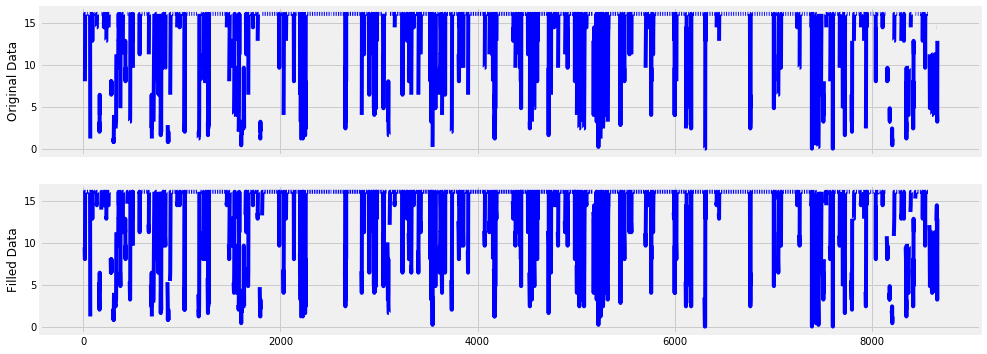

In [27]:
def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan

    return filled

field='Visibility'
#field='Dew_Point'
#field='Solar_KWH'
year='2010'
chtitle=field
#plt.figure(figsize=(15, 6))
#plt.title(chtitle)
#plt.scatter(production_by_year[year].index, production_by_year[year][field])
#plt.xlabel("Date")
#plt.ylabel("y-label")
#plt.show()
#print(production_by_year[year][field].head())


# Let's plot the results
x=production_by_year[year][field].values

# Interpolate small gaps using numpy
filled = interpolate_gaps(x, limit=2)

# Let's plot the results
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15, 6))
axes[0].plot(x, color='blue')
axes[1].plot(filled, color='blue')

axes[0].set(ylabel='Original Data')
axes[1].set(ylabel='Filled Data')
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for year in production_by_year:
    for field in list(production_by_year[year]):
        #field='Dew_Point'
        chtitle=year + ' ' + field
        production_by_year[year][field].plot(figsize=(15, 6),
                                             title=chtitle)
        plt.show()
        result = seasonal_decompose(production_by_year[year][field], model='additive', freq=3);
        #print(result)
        result.plot()


# We can see in plots that there is some seasonality component.
# We need to decompose this.
# From: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c



In [ ]:
# Split each dataset into train-test
X_sol = pd.DataFrame(wind_prod[['Wind_Speed_AT_WINDFARM',
                                 'Cloud_Cover_Fraction',
                                 'Dew_Point',
                                 'Humidity_Fraction',
                                 'Precipitation',
                                 'Pressure',
                                 'Temperature',
                                 'Visibility',
                                 'Wind_Speed_AT_SOLARRAY']])
y_sol = pd.Series(wind_prod['Wind_KWH'])
X_train_sol, X_test_sol, y_train_sol, y_test_sol = train_test_split(X_sol,
                                                                    y_sol, 
                                                                    test_size=0.4,
                                                                    random_state=0)

# Model.fit
# Report results.
# Vary parameters, lather, rinse, repeat.


In [ ]:
# Lets check for autocorrelation between variables.

#corr_list = production.corr().abs()
#ordered_list = corr_list.unstack()
#ordered_list = ordered_list.sort_values(kind="quicksort", ascending=False)
#print(ordered_list)

#series = Series.from_csv('daily-minimum-temperatures.csv', header=0)
plot_acf(production)
pyplot.show()
#plot_pacf(production, lags=50)
#pyplot.show()

In [ ]:
# fit model
"""
From the documentation:
Parameters:
endog (array-like) – The endogenous variable.
"""
solar_endog='Solar_KWH'
wind_endog='Wind_KWH'
"""
order (iterable) – The (p,d,q) order of the model for the number of AR parameters, 
differences, and MA parameters to use.
"""
diff=('TBD')
"""
exog (array-like, optional) – An optional array of exogenous variables. 
This should not include a constant or trend. You can specify this in the fit method.
"""
solar_exog=['Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
wind_exog=['Wind_Speed_AT_WINDFARM',
           'Solar_Elevation',
           'Cloud_Cover_Fraction',
           'Dew_Point',
           'Humidity_Fraction',
           'Precipitation',
           'Pressure',
           'Temperature',
           'Visibility',
           'Wind_Speed_AT_SOLARRAY']
"""
dates (array-like of datetime, optional) – An array-like object of datetime objects. 
If a pandas object is given for endog or exog, it is assumed to have a DateIndex.
"""
dates=production.index
"""
freq (str, optional) – The frequency of the time-series. A Pandas offset or ‘B’, ‘D’, ‘W’, ‘M’, ‘A’, or ‘Q’. This is optional if dates are given.
"""
freq='D'  # We want to predict the next day
"""

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())
"""